# 哈密尔顿蒙特卡洛（Hamiltonian Monte Carlo）

Metropolis-Hastings 采样方法的一个问题是它会展现出随机漫步式的行为，而随机漫步对参数空间的探索效率并不高——平均来说探索的距离与步数的平方根成正比（$\sqrt{n}$，参考 [Random Walks in 1 dimension](http://www.mit.edu/~kardar/teaching/projects/chemotaxis%28AndreaSchmidt%29/random.htm)）。而简单的扩大步幅又会降低接受率。哈密尔顿蒙特卡洛（HMC）方法提供了一个新思路，即可以提高参数空间的探索效率，又能保持较高的接受率。

## 哈密尔顿动力学

介绍 HMC 采样方法之前需要先简单说一下哈密尔顿动力学。

哈密尔顿（爱尔兰人 1805-1865）在拉格朗日力学的基础上对经典的牛顿力学做了全新的解释。牛顿力学强调，加速度，作为力作用到物体上的效果，是位置（距离）对时间的二阶导数。引入速度可以把二阶导分解成两个一阶导：速度是位置（距离）对时间的一阶导数，而加速度是速度对时间的一阶导数。

考虑地球引力与物体组成的动力系统。每个单位重量（$m=1$）的物体在高度为 $h$ 的地方具有势能（potential energy） $E_p(h) = mgh = gh$，其中 $g$ 为加速度，也是重力，且 $g = \frac{\partial E_p}{\partial h}$。在物体自由落体的时候（忽略空气阻力等其他因素），物体的速度对时间的导数也是 $g$，即 $\frac{dv}{dt} = g$。所以速度对时间的导数等于势能对位置（高度）的导数：$\frac{dv}{dt} = \frac{\partial E_p}{\partial h}$。

而单位重量（$m=1$）的物体运动中的动能（kinetic energy）为 $E_k(v) = \frac{mv^2}{2} = \frac{v^2}{2}$，动能对速度的导数是 $\frac{\partial E_k}{\partial v} = v$。同时速度又是位置（高度）对时间的导数 $\frac{dh}{dt} = -v$，其中负号表示反向（速度增加对应高度降低）。所以位置（高度）对时间的导数等于反向的动能对速度的导数 $\frac{dh}{dt} = -\frac{\partial E_k}{\partial v}$。

考虑势能和动能组成的能量系统：$H(h, v) = E_p(h) + E_k(v)$，其中 $H$ 是哈密尔顿函数。上面的微分等式可以使用哈密尔顿函数重新表述为：

\begin{align}
\frac{dv}{dt} & = \frac{\partial E_p}{\partial h} = \frac{\partial H}{\partial h}\\
\frac{dh}{dt} & = -\frac{\partial E_k}{\partial v} = -\frac{\partial H}{\partial v}
\end{align}

上面即是哈密尔顿等式。

在系统的演化过程中（物体降落），哈密尔顿函数的值是不变的：

\begin{align}
\frac{dH}{dt} & = \frac{\partial H}{\partial h}\frac{dh}{dt} + \frac{\partial H}{\partial v}\frac{dv}{dt}\\
              & = -\frac{\partial H}{\partial h}\frac{\partial H}{\partial v} + \frac{\partial H}{\partial v}\frac{\partial H}{\partial h}\\
              & = 0
\end{align}

可以理解为物体增加的动能等于减少的势能，即能量守恒。

哈密尔顿等式中的 $h$ 和 $v$ 是联动且一一对应的，而 $(h, v)$ 组成的空间称为相空间（phase space）。一个物体的下落过程在 $(h, v)$ 相空间中表现为一个等值曲线（哈密尔顿函数值）。不同的初始设定 $(h_0, v_0)$ 确定了不同的等值曲线（当然对应不同的哈密尔顿函数值）。

## 动力系统与概率分布

上面的动力学和概率分布有什么关系呢？如果用相空间上的位置 $h$ 表示目标分布 $p(z)$ 的变量 $z$（后面的位置都用 $z$ 表示），希望可以设计一个合适的动力系统来遍历相空间，使得遍历（采样）得到的点 $(z_0, v_0), (z_1, v_1), \ldots , (z_n, v_n)$ 中的 $z_i$ 符合目标分布。

下面来看设计思路。

首先，（任何）概率分布 $p(z)$ 都可以重新表示为 $\frac{1}{Z_p}exp(-(-log(p(z))))$。设 $E(z) = -log(p(z))$，则 $p(z) = \frac{1}{Z_p}exp(-E(z))$，其中 $E(z)$ 可以理解为势能。

接下来引入动能 $K(v) = \frac{v^2}{2}$，和对应的概率分布 $p(v) = \frac{1}{Z_k}exp(-K(v))$。


设哈密尔顿函数是 $H(z,v) = E(z) + K(v)$，则由 $z$ 和 $v$ 组成的联合分布可以表示为：

$$
p(z, v) = p(z)p(v) = \frac{1}{Z_H}exp(-(E(z) + K(v))) = \frac{1}{Z_H}exp(-H(z, v)).
$$

如果能以符合 $p(z, v)$ 分布的方式对相空间 $(z, v)$ 遍历（采样），那得到的 $z_i$ 将符合 $z$ 的边际分布，也是目标分布 $p(z)$。

### 采样

对 $p(z, v)$ 的采样可以借鉴 Metropolis 方法：

1. 选取初始样本 $(z_i, v_i)$
1. 执行提议过程（要求对称）得到 $(z^*, v^*)$
  1. 以 $min\left(1, \frac{p(z^*, v^*)}{p(z_i, v_i)}\right)$ 的概率接受 $(z_{i+1}, v_{i+1}) = (z^*, v^*)$
  1. 否则 $(z_{i+1}, v_{i+1}) = (z_i, v_i)$
1. 重复第 2 步

HMC 与 Metropolis 所不同的就是对新样本的提议过程。HMC 通过对动力系统的模拟演化来提议新样本，即以 $(z_i, v_i)$ 为初始状态，按照哈密尔顿等式，通过固定时间（固定步数）的迭代得到 $(z^*, v^*)$。理论上，哈密尔顿等式保证了 $H$ 是恒定的，$p(z^*, v^*) = p(z_i, v_i)$，新样本必然会被接受。也正是这个特性保证了 HMC 较高的接受率。但在实际的计算过程中是通过离散的方法模拟连续的过程，必然会出现误差，所以依然使用 Metropolis 方法来判断是否接受新样本，以此来保证所有样本符合 $p(z, v)$ 分布。

对哈密尔顿等式的计算通常采样“青蛙跳（leapfrog）”的方法模拟：
\begin{align}
\widehat{v}(t+\epsilon / 2) & = \widehat{v}(t) + \frac{\epsilon}{2}\frac{\partial E}{\partial z}(\widehat{z}(t))\\
\widehat{z}(t+\epsilon / 2) & = \widehat{z}(t) - \epsilon\frac{\partial K}{\partial v}(\widehat{v}(t+\epsilon / 2)) = \widehat{z}(t) - \epsilon \widehat{v}(t+\epsilon / 2)\\
\widehat{v}(t+\epsilon) & = \widehat{v}(t+\epsilon / 2) + \frac{\epsilon}{2}\frac{\partial E}{\partial z}(\widehat{z}(t+\epsilon))
\end{align}
，其中 $\epsilon$ 表示步幅系数。上面是一个完整的步骤，而模拟过程通常是循环固定的次数（$L$，可调整的参数）。这个步骤简单解释起来是 $v$ 先前进半步（$\frac{\epsilon}{2}$），然后 $z$ 前进一步（$\epsilon$），最后 $v$ 再前进半步（$\frac{\epsilon}{2}$）。在循环多次的情况下，上一次最后对 $v$ 的调整可以和下一次开头对 $v$ 的调整合并为一步。

Metropolis 方法要求提议的过程的对称的，这个可以通过随机采用 $\epsilon$ 或者 $-\epsilon$ 来保证，即在相空间中是正向前进还是反向前进。“青蛙跳”的过程保证，从 $(z_i, v_i)$ 正向前进到 $(z^*, v^*)$ 后，反向经过相同的步数可以准确回到 $(z_i, v_i)$。（满足 detailed balance 的证明过程可以参考 PRML 11.5.2）

#### 遍历

上面的过程保证了较高的接受率，但是提议过程并不完整。因为给定初始的 $(z_0, v_0)$ 后，后续的样本都保持 $H(z_i, v_i)$ 恒定，也就是 $p(z_i, v_i)$ 是固定的。这样显然不能遍历整个的 $p(v, v)$ 分布。

解决办法是，在下次执行哈密尔顿模拟过程之前，从条件分布 $p(v_i^{'} \mid z_i)$ 中采样出一个新的 $v_i^{'}$，以 $(z_i, v_i^{'})$ 作为模拟过程的初始点。这个过程实际是选择了一个不同 $H$ 值，也就选择了一个不同的等值曲线。

像 Gibbs 方法一样，从条件分布中采样并没有破坏 $p(z, v)$ 分布。由于 $p(z, v)$ 中 $z$ 和 $v$ 是相互独立的，所以 $p(v \mid z) = p(v)$，即可以直接从 $p(v)$ 采样。根据上面对动能 $K(v)$ 的定义，可以直接从标准的高斯分布中采样 $Normal(0, 1)$。



所以总结起来，HMC 的提议过程分两步：
1. 从 $p(v \mid z) = p(v)$ 中采样出 $v_i^{'}$
1. 与上一次的 $z_i$ 组成新的初始点 $(z_i, v_i')$，然后运行一定次数的“青蛙跳”，得到提议的样本 $(z^{*}, v^{*})$

有了 $(z^{*}, v^{*})$ 接下再执行依据 $min(1, \cdots)$ 概率的选择过程。

上面提议过程的步骤里，一个是从条件分布里采样，另一个是 Metroplis 过程，都没有改变 $p(z, v)$ 分布。虽然这可以理解为依据上面的步骤得出的样本符合目标分布，但是如果能够证明这两步**作为一个整体**满足 detailed balance 条件，就能更好的理解这个方法。以后会跟进分析。

## 例子

例子中的目标分布是一个高斯混合分布，中心点分别在 4 和 7，权重分别是 0.3 和 0.7。例子使用 [PyTorch](https://pytorch.org/) 实现，因为 PyTorch 提供了比较方便的计算梯度的方法。

完整的实现在 [Hamiltonian-Monte-Carlo-import.ipynb](Hamiltonian-Monte-Carlo-import.ipynb) 文件中，下面只列出了关键的步骤。

In [4]:
%%capture
%run Hamiltonian-Monte-Carlo-import.ipynb

定义目标概率分布：

In [2]:
def ptilde(x):
    return 0.3 * normpdf(x, mean=torch.tensor(4.0), scale=torch.tensor(1.0)) + 0.7 * normpdf(x, mean=torch.tensor(7.0), scale=torch.tensor(1.0))

下面看一下目标分布的密度函数曲线：

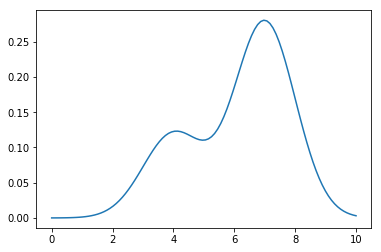

In [5]:
x = th.tensor(np.linspace(0, 10, num=100))
y = x.clone().apply_(ptilde)
plt.plot(np.array(x), np.array(y))

在引入动能之后，$p(z, v)$ 的分布的等值曲线是这样的：

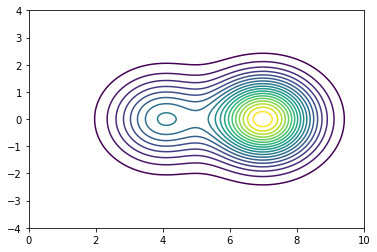

In [11]:
levels = np.arange(0,0.3,0.015)
contour(xx, yy, zs, levels=levels)

右边紧密排列的圆是高密度区域。

然后定义在 $p(z, v)$ 中采样的过程。

首先是青蛙跳的步骤。这里已经把中间步骤里前后两次对 $v$ 的半步前进合并成一步前进：

In [7]:
def leapfrog2(z, r, e=torch.tensor(0.001), L=100):
    if randint(1,2) == 1:
        e = -e
    z.requires_grad_(True)
    E = -torch.log(ptilde(z))
    E.backward()
    rhalf = r - 0.5 * e * z.grad
    rnext = rhalf
    znext = z

    for _ in range(L):
        with torch.no_grad():
            znext = znext + e * rnext
        znext.requires_grad_(True)
        E2 = -torch.log(ptilde(znext))
        E2.backward()
        with torch.no_grad():
            rnext = rnext - e * znext.grad

    with torch.no_grad():
        rnext = rnext + 0.5 * e * znext.grad

    return znext, rnext

然后是采样步骤：

In [8]:
def hmc2():
    n = 5000
    zs = []
    rs = []
    z0 = torch.tensor(4.0)
    for _ in range(n):
        r0 = torch.randn(1)
        zn, rn = leapfrog2(z0, r0, e=torch.tensor(0.15), L=20)
        nH = Hamilton(zn, rn)
        oH = Hamilton(z0, r0)
        if random.random() <= torch.exp(nH - oH):
            z0 = zn
        zs.append(z0.item())

    _ = hist(zs, bins=150)

采样结果，z 的直方图：

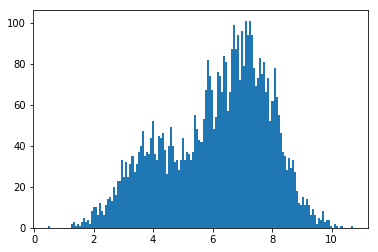

In [9]:
hmc2()

大致符合目标分布。下面跟其他实现方式比较一下。

首先是 Metropolis 方法：

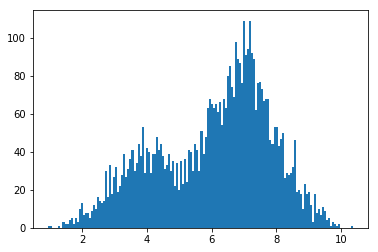

In [12]:
metropolis()

然后是 [PyMC3](https://docs.pymc.io/) 提供的 HMC 方法：

100%|██████████| 5500/5500 [00:02<00:00, 2058.43it/s]


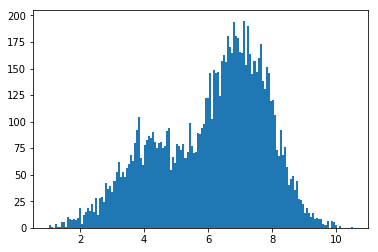

In [13]:
pymc3_hmc()

可以看到上面实现的 HMC 方法还是基本得到了正确的分布。

## 讨论

但是 HMC 引入额外的维度（参数，也就是动能）的意义是什么，为什么它能提高参数空间的探索效率？

下面先看一下连续的几次采样过程，包括青蛙跳的轨迹（下面 Traj 类的第二个参数是初始的 $z$ 值）：

In [16]:
%%capture
fig, ax = plt.subplots()
levels = np.arange(0,0.3,0.015)
ax.contour(xx, yy, zs, levels=levels)
traj = Traj(ax, 4.0)
anim = FuncAnimation(fig, traj, frames=np.arange(200), init_func=traj.init, interval=200, blit=True)

In [17]:
anim

首先可以看出，青蛙跳的轨迹确实是沿着等值密度线前进。另外，在密度较高的地方，前进的步幅较小。还有，在右面密度最高的区域里，这些等值线与左边区域没有联通，所以落在这些圆上的点在青蛙跳之后依然会留在附近。这些都保证了 $p(z)$ 大的地方得到更多的样本。

回到上面额外维度的问题。引入额外维度的意义在于可以实现飞跃，即不必受限于原有空间的沟沟坎坎而可以轻松的从 A 地到 B 地。如果跟飞机比的话，地上的火车可以认为是在二维的空间中前行。而有了飞机之后其实是增加了一个维度，可以不再受地面上各种条件的限制，可以实现（在地面看来）快速无痕迹的从 A 地到 B 地。

结合到上面的例子可以看出，如果初始点是在 $p(z)$ 较低的地方，HMC 会以较大的步幅前进，快速的离开。

另外，哈密尔顿等式的应用保证了 $H$ 基本恒定，新提议的样本会以较高的概率被接受。

遗留的问题是，提议过程的两个步骤（条件分布采样和青蛙跳+Metropolis过程）**作为一个整体**是如何满足 detailed balance 条件的。这个问题以后会继续分析。